In [25]:
import pandas as pd
import spacy
from neo4j import GraphDatabase
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt


#!python -m spacy download en_core_web_sm

In [26]:
# Load the dataset
df = pd.read_csv('Dataset.csv')
df = df.drop(columns=['Unnamed: 0'])

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')


In [27]:
# Check for missing values
print(df['statement'].isnull().sum())

# Fill missing values with an empty string (or any placeholder you prefer)
df['statement'] = df['statement'].fillna('')

# Convert the 'statement' column to strings
df['statement'] = df['statement'].astype(str)

362


In [28]:
# Function to process in batches
def process_batch(texts):
    docs = list(nlp.pipe(texts))
    entities = []
    relationships = []
    for doc in docs:
        ents = [(ent.text, ent.label_) for ent in doc.ents]
        rels = [(token.head.text, token.text, token.dep_) for token in doc if token.dep_ in ('amod', 'nsubj', 'dobj')]
        entities.append(ents)
        relationships.append(rels)
    return entities, relationships

# Apply in batches
batch_size = 1000
entities_list = []
relationships_list = []

for i in tqdm(range(0, len(df), batch_size)):
    batch_entities, batch_relationships = process_batch(df['statement'][i:i+batch_size])
    entities_list.extend(batch_entities)
    relationships_list.extend(batch_relationships)

df['entities'] = entities_list
df['relationships'] = relationships_list


100%|██████████| 54/54 [13:45<00:00, 15.30s/it]


In [30]:
# Saving generated df, to reuse later, save time
df.to_csv('dataset_with_entities_and_relationships.csv')

Adding Edges: 100%|██████████| 53043/53043 [00:02<00:00, 18691.24it/s]


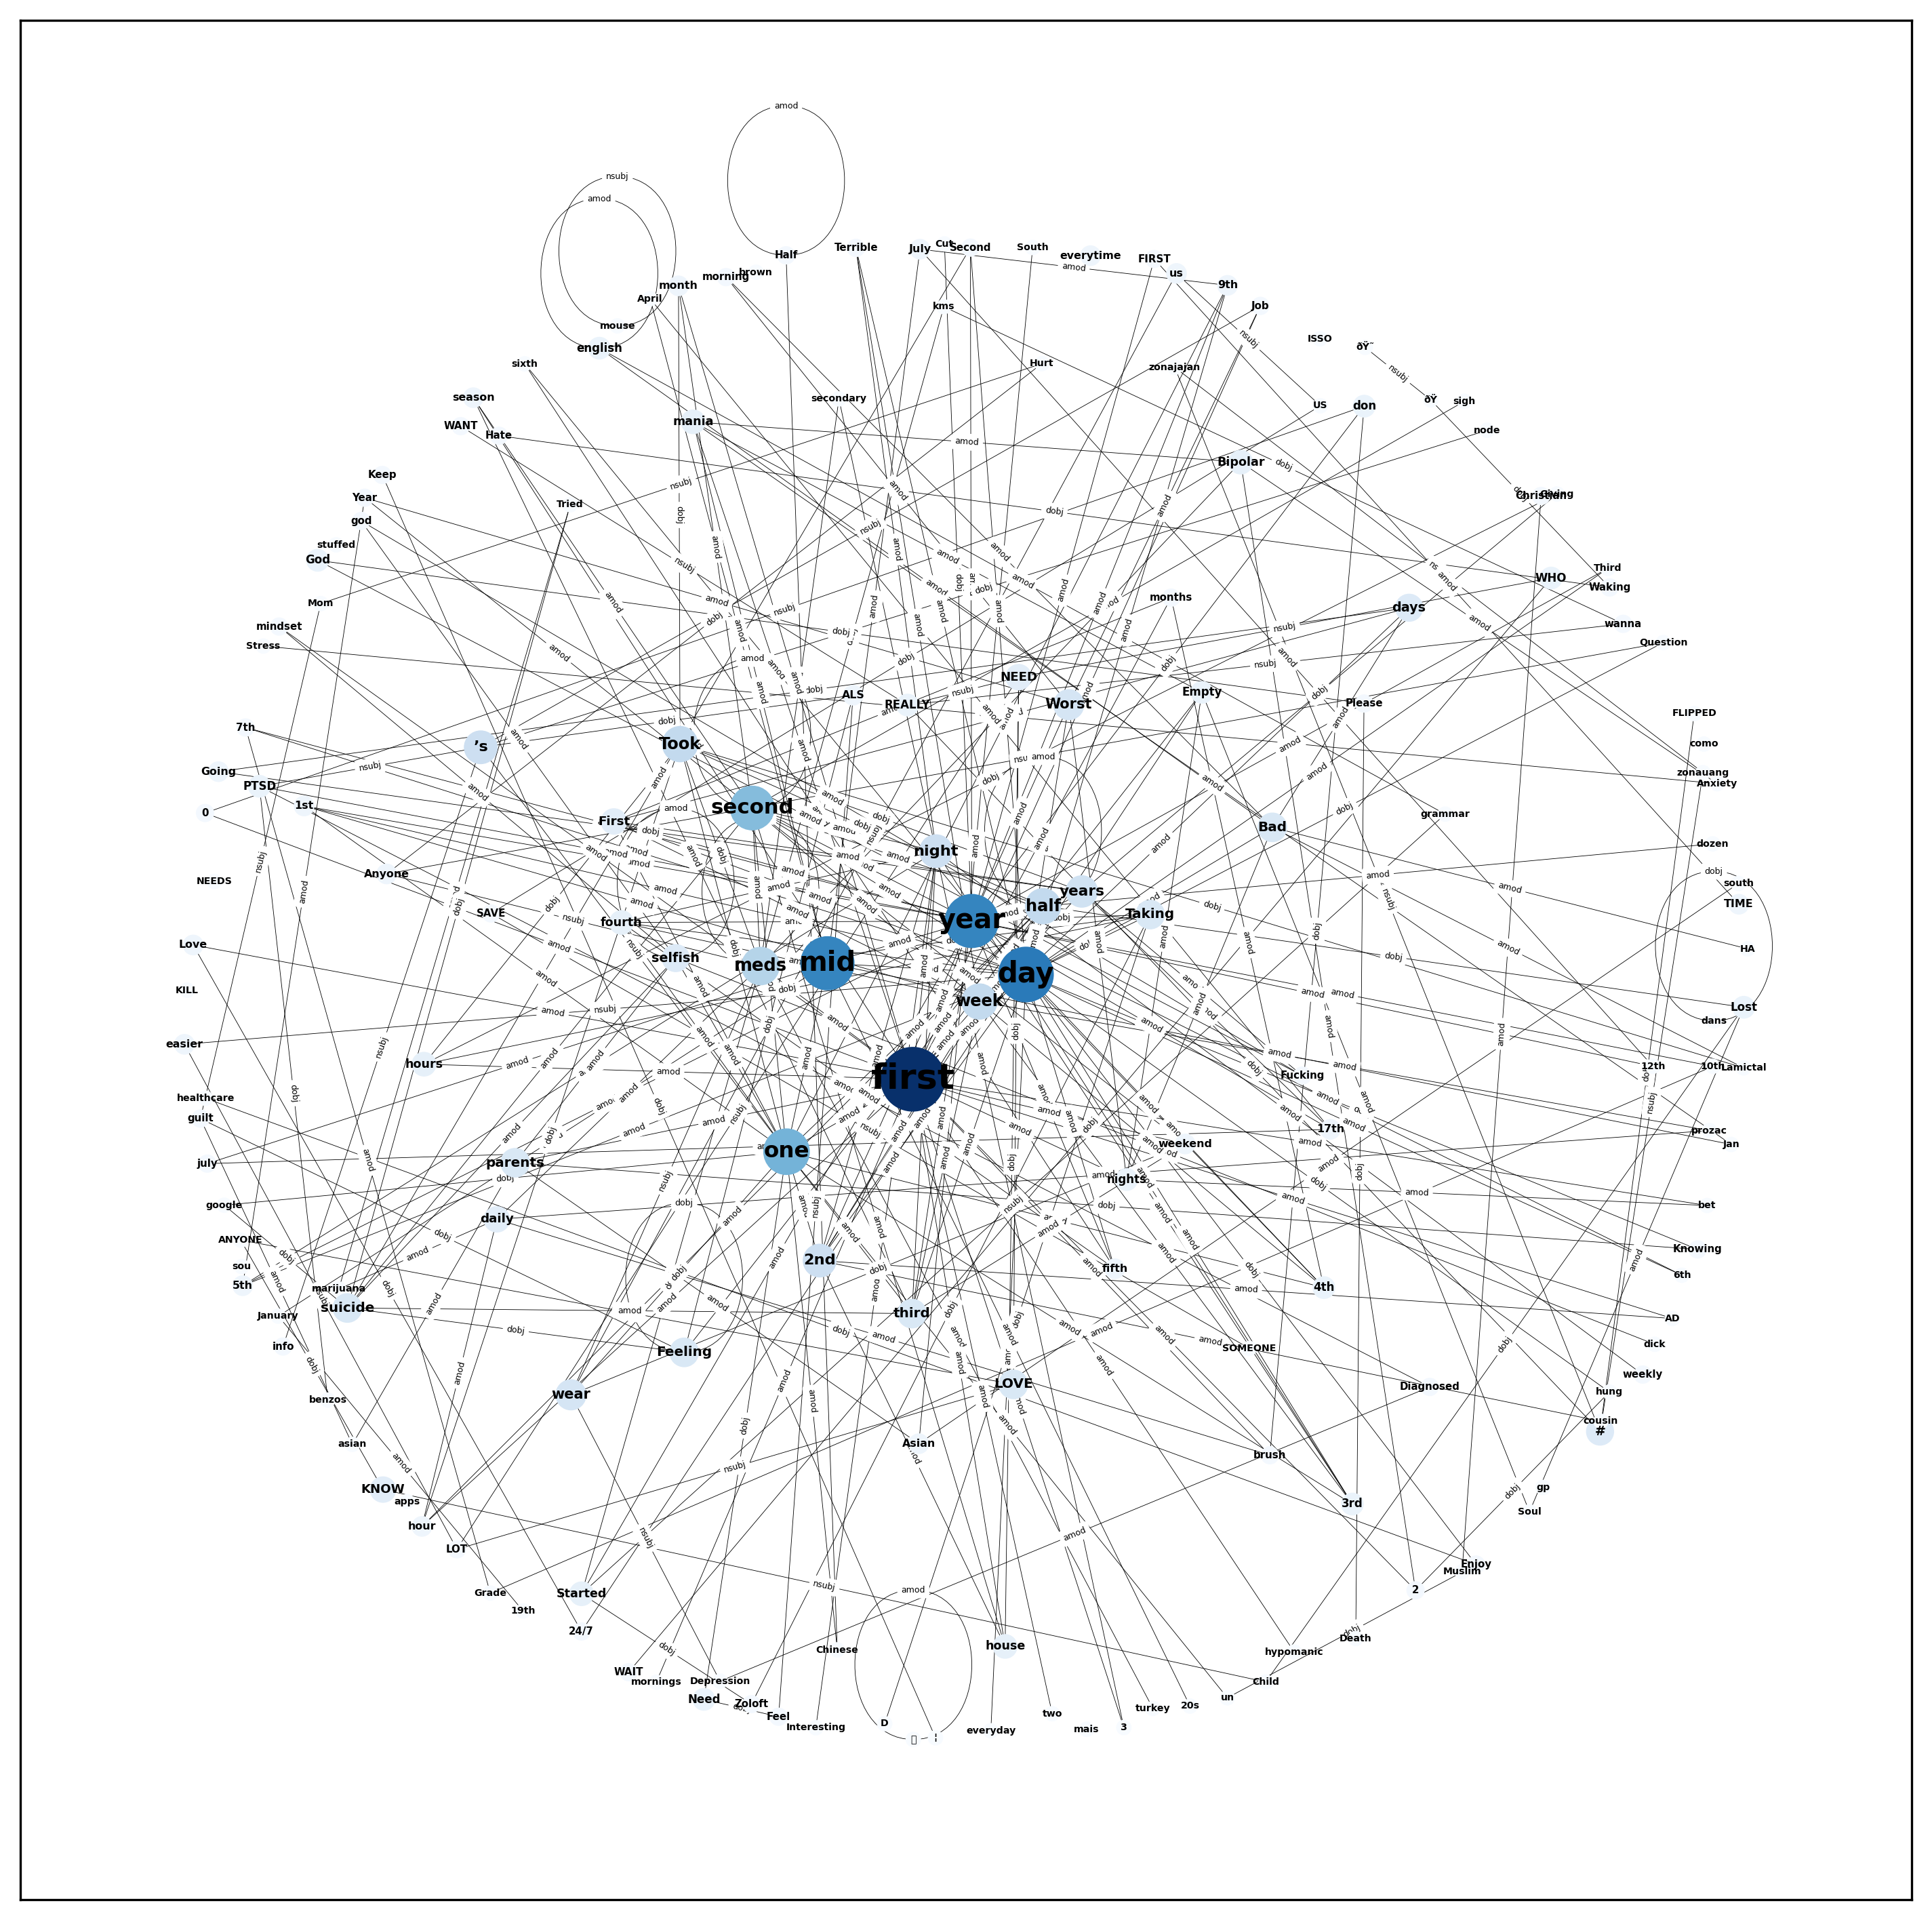

In [110]:
# Create a graph
G = nx.Graph()

# Add nodes to the graph from the DataFrame
for _, row in tqdm(df.iterrows(), total=len(df), desc="Adding Nodes"):
    entities = row['entities']
    for entity, label in entities:
        G.add_node(entity, label=label)

# Add edges to the graph from the DataFrame
for _, row in tqdm(df.iterrows(), total=len(df), desc="Adding Edges"):
    relationships = row['relationships']
    for head, tail, rel in relationships:
        if G.has_node(head) and G.has_node(tail):
            G.add_edge(head, tail, relation=rel)

# Filter nodes by degree (e.g., only nodes with degree >= 2)
filtered_nodes = [node for node, degree in G.degree() if degree >= 2]
subgraph = G.subgraph(filtered_nodes)

# Adjust spring_layout parameters for better spacing
#pos = nx.shell_layout(subgraph, scale = 0.2)

pos = nx.spring_layout(subgraph, k=5, iterations=300)  # Adjust k and iterations as needed


# Create a high-resolution plot
plt.figure(figsize=(12, 12), dpi=300)  # Adjust figsize and dpi for higher resolution

# Draw nodes with different sizes and colors
node_sizes = [G.degree(n) * 10 for n in subgraph.nodes()]
node_colors = [G.degree(n) for n in subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues)

# Example: Vary edge width based on relationship type
edge_widths = []
for (n1, n2, data) in subgraph.edges(data=True):
    if data['relation'] == 'negative':
        edge_widths.append(0.3)
    else:
        edge_widths.append(0.2)

nx.draw_networkx_edges(subgraph, pos, width=edge_widths)

# Draw labels with font size proportional to node degree
labels = {node: node for node in subgraph.nodes()}
font_sizes = {node:  3 + 0.2 * G.degree(node) for node in subgraph.nodes()}
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=font_sizes[node], ha='center', va='center', fontweight='bold')

# Draw edge labels with smaller font size
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=3)

# Show the plot
plt.show()
